## Unbalanced Gromov-Wasserstein for SCOT

SCOT using the balanced case of Gromov-Wasserstein is sensitive to mass imbalance. By making some changes, we can get SCOT to run with using **Unbalanced Gromov-Wasserstein** instead [Sejourne 2020]. 
This fork of SCOT depends on Thibault Sejourne's PyTorch implementation of the entropic unbalanced GW solver [here](https://github.com/thibsej/unbalanced_gromov_wasserstein)

We demonstrate this fact in this notebook by considering the problem of aligning two datasets generated by sampling from a wishbone-shaped structure with 3 branches. Each dataset is sampled from the structure with different density profiles, such that there some branches are underrepresented/overrepresented in each dataset.


### References
[Sejourne 2020] Séjourné, T., Vialard, F.X. and Peyré, G., 2020. The Unbalanced Gromov Wasserstein Distance: Conic Formulation and Relaxation. arXiv preprint arXiv:2009.04266.

In [1]:
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt

In [2]:
# generate example data
def f(t, p = 0.5, t0 = 0.3):
    if t < t0:
        x = np.array([t, 0, 0]) 
        x[0:2] += np.random.randn(2)*0.05
    else: 
        if np.random.rand() < p:
            x= np.array([t, np.tanh(t-t0), 1])
            x[0:2] += np.random.randn(2)*0.05
        else: 
            x= np.array([t, -np.tanh(t-t0), 2])
            x[0:2] += np.random.randn(2)*0.025
    return x
        
def h1(x):
    return np.array([x[0]*np.cos(3*x[0]), x[1], x[0]*np.sin(3*x[0])])

def h2(x):
    return np.array([x[0]*np.sin(2*x[0]), x[1], x[0]*np.cos(2*x[0]), x[0]**2 + x[1]**2])

Below, we see that $X_1$ and $X_2$ are samplings from the same underlying structure, but in $X_1$ both green (branch 1) and yellow (branch 2) branches have equal densities, and in $X_2$ green and yellow branches are sampled in a ratio 1:3. Additionally, in $X_1$ we sample for uniform $t \in [0, 1]$ but for $X_2$ we take $t = \mathcal{N}(0, 1) \text{ mod } 1$.

X_1: prop1/prop2 = 1.145062
X_2: prop1/prop2 = 0.346693


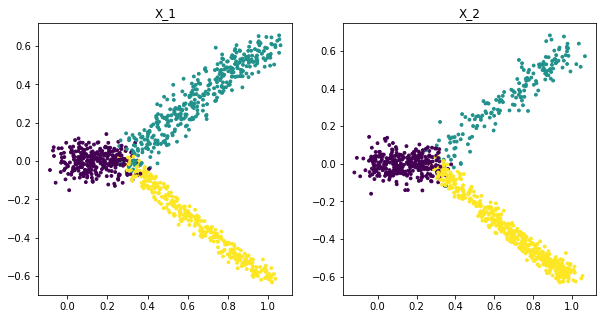

In [3]:
N = 1000
t_range_1 = np.random.uniform(0, 1, N)
X1 = np.stack([f(t) for t in t_range_1])
X1_branch = X1[:, 2]
X1 = X1[:, 0:2]

t_range_2 = np.random.normal(loc = 0, scale = 0.3, size = N) % 1
X2 = np.stack([f(t, p = 0.25) for t in t_range_2])
X2_branch = X2[:, 2]
X2 = X2[:, 0:2]
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.scatter(X1[:, 0], X1[:, 1], alpha = 1, c = X1_branch, s = 8)
plt.title("X_1")
plt.subplot(1, 2, 2)
plt.scatter(X2[:, 0], X2[:, 1], alpha = 1, c = X2_branch, s = 8)
plt.title("X_2")

print("X_1: prop1/prop2 = %f" % ((X1_branch == 1).mean()/(X1_branch == 2).mean()))
print("X_2: prop1/prop2 = %f" % ((X2_branch == 1).mean()/(X2_branch == 2).mean()))

We also apply nonlinear maps $h_1 : \mathbb{R}^2 \to \mathbb{R}^4$ and $h_2 : \mathbb{R}^2 \to \mathbb{R}^3$ to get the data into different domains

Text(0.5, 0.92, 'Projection 2 ($h_2$)')

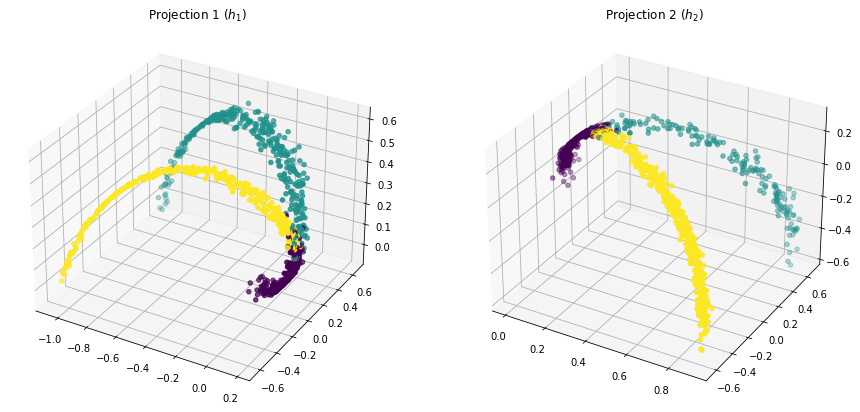

In [4]:
Y1 = h1(X1.T).T
Y2 = h2(X2.T).T

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (15, 7.5))
ax = fig.add_subplot(121, projection='3d')
ax.scatter3D(Y1[:, 0], Y1[:, 1], Y1[:, 2], c = X1_branch)
plt.title("Projection 1 ($h_1$)")
ax = fig.add_subplot(122, projection='3d')
ax.scatter3D(Y2[:, 0], Y2[:, 1], Y2[:, 2], c = X2_branch)
plt.title("Projection 2 ($h_2$)")

In [5]:
import sys
sys.path.insert(1, '../src/')
import utils as ut
import evals as evals
import scot2 as sc

Now we apply the $z$-score procedure as per SCOT and apply SCOT alignment with both balanced and unbalanced Gromov-Wasserstein 

In [ ]:
X1_scaled = ut.zscore_standardize(Y1)
X2_scaled = ut.zscore_standardize(Y2)

# initialize SCOT object
scot=sc.SCOT(X1_scaled, X2_scaled)
# call the balanced alignment
X1_new_bal, X2_new_bal = scot.align(k=25, e=1e-3,  normalize=False,balanced = True)
gamma_bal = scot.coupling

It.  |Err         
-------------------
    0|8.994855e-04|
   10|3.272794e-04|
   20|2.286710e-04|
   30|1.679492e-04|
   40|1.336056e-04|
   50|7.199078e-05|
   60|4.945177e-05|


In [ ]:
# call the unbalanced alignment 
X1_new_unbal, X2_new_unbal = scot.align(k=25, e=1e-3, rho = 0.01, normalize=False,  balanced = False)
gamma_unbal = scot.coupling
gamma_unbal = gamma_unbal/gamma_unbal.sum()

Now using the obtained couplings, we project the dataset $X_1$ onto the domain of dataset $X_2$ via barycentric projection. Observe how in $X_1$, the green branch (branch 1) is overrepresented compared to its corresponding branch in $X_2$. Using balanced GW, we find that some of the excess green mass gets mapped onto the yellow branch (branch 2). Unbalanced GW avoids this.

In [33]:
P = (gamma_unbal.T/gamma_unbal.sum(1)).T
X1_new_unbal = P @ X2_scaled

Text(0.5, 0.92, 'Unbalanced GW')

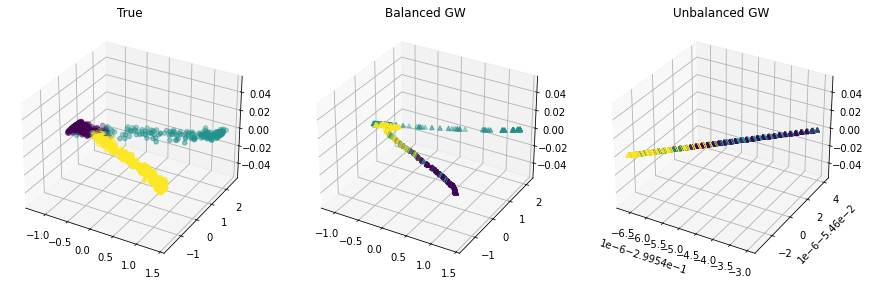

In [34]:
fig = plt.figure(figsize = (15, 5))
ax = fig.add_subplot(131, projection='3d')
ax.scatter3D(X2_new_bal[:, 0], X2_new_bal[:, 1], c = X2_branch, marker = "o")
plt.title("True")
ax = fig.add_subplot(132, projection='3d')
ax.scatter3D(X1_new_bal[:, 0], X1_new_bal[:, 1], c = X1_branch, marker = "^")
plt.title("Balanced GW")
ax = fig.add_subplot(133, projection='3d')
ax.scatter3D(X1_new_unbal[:, 0], X1_new_unbal[:, 1], c = X1_branch, marker = "^")
plt.title("Unbalanced GW")

Here, we let $\pi_0$ be uniform on points that are branch 1 in $X_1$, and we compute $\pi_0 P$ where $P$ is the transition matrix that we get by row-normalising the GW coupling matrix. This shows us where all the mass from branch 1 goes when we project to $X_2$ coordinates...

Text(0.5, 1.0, 'Balanced GW, err = 0.803')

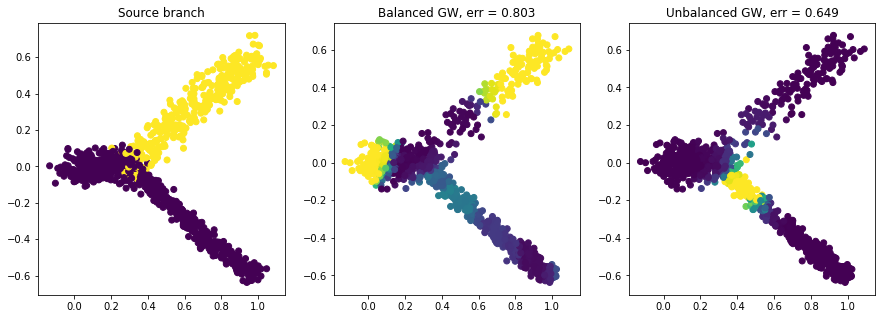

In [35]:
plt.figure(figsize = (15, 5))
plt.subplot(1, 3, 1)
pi1 = np.ones(X1_branch.shape)
pi1[X1_branch != 1] = 0
plt.scatter(X1[:, 0], X1[:, 1], c = pi1)
plt.title("Source branch")
plt.subplot(1, 3, 3)

P = (gamma_unbal.T/gamma_unbal.sum(1)).T
pi2 = pi1 @ P
mean_err = (P*(X1_branch[:, None] != X2_branch[None, :])).sum(1).mean()

plt.scatter(X2[:, 0], X2[:, 1], c = pi2, vmin = 0, vmax = np.quantile(pi2, 0.95))
plt.title("Unbalanced GW, err = %0.3f" % mean_err)
plt.subplot(1, 3, 2)

P = (gamma_bal.T/gamma_bal.sum(1)).T
pi1 = np.ones(X1_branch.shape)
pi1[X1_branch != 1] = 0
pi2 = pi1 @ P
mean_err = (P*(X1_branch[:, None] != X2_branch[None, :])).sum(1).mean()

plt.scatter(X2[:, 0], X2[:, 1], c = pi2, vmin = 0, vmax = np.quantile(pi2, 0.95))
plt.title("Balanced GW, err = %0.3f" % mean_err)